# Environment

In [52]:
import os
import pandas as pd
import pysam
import pandas as pd
import os
import pandas as pd
import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, r
import rpy2.robjects as ro
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pandas as pd
import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, r, Formula
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import StrVector, DataFrame
import shutil


In [2]:
# Set up the working directory
data_dir = "/beegfs/scratch/ric.broccoli/ric.broccoli/PW_RNA_seq_deep"
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)

In [3]:
# Enable automatic conversion between pandas and R dataframes
pandas2ri.activate()

In [4]:
# Import necessary R packages
dexseq = importr('DEXSeq')
deseq2 = importr('DESeq2')

In [5]:
import pandas as pd
import glob
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

def process_file(file):
    # Read the file
    df = pd.read_csv(file, sep='\t', header=None, names=['feature_id', 'count'])

    # Function to process feature_id
    def process_feature_id(fid):
        # Remove leading and trailing quotes
        fid = fid.strip('"')
        # Check if it's a special entry
        if fid.startswith('_'):
            return pd.Series({'gene_id': fid, 'exon_id': None})
        elif ':' in fid:
            # Split into gene_id and exon_id
            gene_id, exon_id = fid.split(':')
            return pd.Series({'gene_id': gene_id, 'exon_id': exon_id.strip('"')})
        else:
            # Handle any unexpected format
            return pd.Series({'gene_id': fid, 'exon_id': None})

    # Apply the function to the feature_id column
    feature_split = df['feature_id'].apply(process_feature_id)
    df['gene_id'] = feature_split['gene_id']
    df['exon_id'] = feature_split['exon_id']

    # Rearrange columns
    df_formatted = df[['gene_id', 'exon_id', 'count']]

    # Save the formatted file
    output_dir = os.path.join(working_dir, 'DexSeq_counts')
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, os.path.basename(file).replace('.dexeq_counts', '.formatted.counts'))
    df_formatted.to_csv(output_file, sep='\t', header=False, index=False, na_rep='None')

    return f"Formatted file saved to: {output_file}"

# Get a list of your count files
data_dir = "/beegfs/scratch/ric.broccoli/ric.broccoli/PW_RNA_seq_deep"
count_files = glob.glob(os.path.join(data_dir, 'DexSeq_counts/*.dexeq_counts'))

# Use all available CPU cores
num_cores = multiprocessing.cpu_count()

# Process files in parallel
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    future_to_file = {executor.submit(process_file, file): file for file in count_files}
    for future in as_completed(future_to_file):
        file = future_to_file[future]
        try:
            print(future.result())
        except Exception as exc:
            print(f'{file} generated an exception: {exc}')

# Read and display the first few lines of the formatted count file
print("\nFirst 10 lines of EDO_1.formatted.counts:")
with open('DexSeq_counts/EDO_1.formatted.counts', 'r') as f:
    for _ in range(10):
        line = f.readline().strip()
        print(line)

Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_2.formatted.counts
Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_2.formatted.counts
Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_1.formatted.counts
Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_1.formatted.counts
Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_3.formatted.counts
Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_3.formatted.counts
Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_2.formatted.counts
Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_1.formatted.counts
Formatted file saved to: /beegfs/scratch/ric.broccoli/kubacki.mi

# Local Functions

In [34]:
def compare_file_structures(file_list):
    """
    Compare structures of multiple DEXSeq count files.
    """
    results = []
    for file_path in file_list:
        with open(file_path, 'r') as f:
            n_lines = sum(1 for line in f)
        file_size = os.path.getsize(file_path)
        results.append({
            'file': os.path.basename(file_path),
            'n_lines': n_lines,
            'size_mb': file_size / 1024 / 1024,
            'avg_line_size': file_size / n_lines if n_lines > 0 else 0
        })
    return pd.DataFrame(results)

def parse_dexseq_id(feature_id):
    """Parse DEXSeq feature ID into gene ID and exon number."""
    if feature_id.startswith('*'):
        return feature_id, None
    try:
        # Format is typically 'ENSG00000000003.14:"001"'
        parts = feature_id.split(':')
        gene_id = parts[0]
        exon_num = parts[1].strip('"')
        return gene_id, exon_num
    except:
        return feature_id, None

def examine_dexseq_file(file_path, n_head=5, n_random=5, n_tail=5):
    """
    Examine a DEXSeq count file in detail with corrected parsing and error handling.
    """
    print(f"\nExamining file: {os.path.basename(file_path)}")
    
    # First, peek at the raw file contents
    print("\nFirst few lines (raw):")
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i < 5:
                print(line.strip())
            else:
                break

    # Read the file with correct column interpretation
    try:
        # Read file with custom separator and column names
        df = pd.read_csv(file_path, sep='\s+', header=None,
                        names=['feature_id', 'count'])
        
        # Convert feature_id to string to handle potential float values
        df['feature_id'] = df['feature_id'].astype(str)
        
        # Split feature_id into gene_id and exon_number
        df['gene_id'], df['exon_number'] = zip(*df['feature_id'].apply(parse_dexseq_id))
        
        # File information
        print(f"\nFile size: {os.path.getsize(file_path) / 1024:.2f} KB")
        print(f"Number of lines: {len(df)}")
        
        # Basic DataFrame information
        print("\nDataFrame Info:")
        print(df.info())
        
        # Print all column names
        print("\nColumn names:")
        print(df.columns.tolist())
        
        # Show first few lines
        print(f"\nFirst {n_head} lines:")
        print(df.head(n_head))
        
        # Basic statistics for counts
        print("\nCount statistics:")
        print(df['count'].describe())
        
        # Additional information
        print("\nNumber of unique genes:", df['gene_id'].nunique())
        print("\nTop 5 genes by total counts:")
        gene_counts = df.groupby('gene_id')['count'].sum().sort_values(ascending=False)
        print(gene_counts.head())
        
        # Check for potential issues
        print("\nChecking for potential issues:")
        issues = []
        if df['count'].isnull().any():
            issues.append("- Contains missing values in counts")
        if (df['count'] < 0).any():
            issues.append("- Contains negative counts")
        if not np.issubdtype(df['count'].dtype, np.number):
            issues.append("- Counts are not numeric")
        if df['feature_id'].dtype != object:
            issues.append(f"- Feature ID column is not string type (current type: {df['feature_id'].dtype})")
            
        # Check for special entries
        special_entries = df[df['feature_id'].str.startswith('*')]
        if not special_entries.empty:
            print("\nSpecial entries found:")
            print(special_entries)
            
        if len(issues) > 0:
            print("\nIssues found:")
            print("\n".join(issues))
        else:
            print("No major issues found")
            
        return df
        
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

def examine_genes_of_interest(df, genes):
    """
    Examine specific genes in the DEXSeq count data.
    """
    print("\nExamining genes of interest:")
    for gene in genes:
        # Find all entries for this gene
        gene_data = df[df['gene_id'].str.contains(gene, na=False)]
        if not gene_data.empty:
            print(f"\n{gene}:")
            print(f"Number of exons: {len(gene_data)}")
            print(f"Total counts: {gene_data['count'].sum()}")
            print(f"Mean counts per exon: {gene_data['count'].mean():.2f}")
            print("\nExon-level data:")
            print(gene_data.sort_values('exon_number'))
            
            # Create plot for this gene
            plt.figure(figsize=(10, 4))
            plt.bar(range(len(gene_data)), gene_data['count'])
            plt.title(f'Exon counts for {gene}')
            plt.xlabel('Exon number')
            plt.ylabel('Counts')
            plt.tight_layout()
            plt.savefig(f'exon_counts_{gene}.pdf')
            plt.close()

def prepare_sample_table(sample_info):
    """
    Prepare sample table in the format required by DEXSeq
    """
    # Filter for EDO and ND1 samples (excluding PW1)
    samples_subset = sample_info[sample_info['condition'].isin(['EDO', 'ND1'])].copy()
    
    # Reset index and ensure proper categorical variables
    samples_subset = samples_subset.reset_index(drop=True)
    samples_subset['condition'] = pd.Categorical(samples_subset['condition'])
    samples_subset['replicate'] = pd.Categorical(samples_subset['replicate'])
    
    return samples_subset

def create_dexseq_object(sample_table, dexseq):
    """
    Create DEXSeqDataSet object from count files
    """
    # Convert sample table to R dataframe
    with localconverter(ro.default_converter + pandas2ri.converter):
        sample_table_r = ro.conversion.py2rpy(sample_table)
    
    # Create formula for the full model
    formula = Formula('~ sample + exon + condition:exon')
    
    # Create formula for the reduced model
    reduced_formula = Formula('~ sample + exon')
    
    # Create DEXSeqDataSet
    dxd = dexseq.DEXSeqDataSetFromHTSeq(
        countfiles=ro.StrVector(sample_table['count_file']),
        sampleData=sample_table_r,
        design=formula,
        flattenedfile=None  # Set to None if you don't have a flattened annotation file
    )
    
    return dxd

def run_dexseq_analysis(dxd, dexseq):
    """
    Run DEXSeq differential exon usage analysis
    """
    # Normalize counts
    dxd = dexseq.estimateSizeFactors(dxd)
    
    # Estimate dispersions
    dxd = dexseq.estimateDispersions(dxd)
    
    # Test for differential exon usage
    dxd = dexseq.testForDEU(dxd)
    
    # Estimate exon fold changes
    dxd = dexseq.estimateExonFoldChanges(dxd)
    
    return dxd

def extract_results(dxd, dexseq):
    """
    Extract and format DEXSeq results
    """
    # Get results table
    res = dexseq.DEXSeqResults(dxd)
    
    # Convert R results to pandas DataFrame
    with localconverter(ro.default_converter + pandas2ri.converter):
        results_df = ro.conversion.rpy2py(res)
    
    # Add adjusted p-value threshold
    results_df['significant'] = results_df['padj'] < 0.05
    
    return results_df

def filter_significant_results(results_df):
    """
    Filter for significant differential exon usage
    """
    # Filter for adjusted p-value < 0.05
    significant_results = results_df[
        (results_df['padj'] < 0.05) & 
        (results_df['log2fold_EDO_ND1'] != 0)
    ].copy()
    
    # Sort by adjusted p-value
    significant_results = significant_results.sort_values('padj')
    
    return significant_results

# DEXSeq Files

## Load Files

In [35]:
# Define paths for DEXSeq count files
dexseq_dir = os.path.join(working_dir, "DexSeq_counts")
count_files = [f for f in os.listdir(dexseq_dir) if f.endswith('.formatted.counts')]

In [36]:
print(count_files)

['EDO_1.formatted.counts', 'ND1_3.formatted.counts', 'PW1_2.formatted.counts', 'EDO_2.formatted.counts', 'ND1_2.formatted.counts', 'EDO_3.formatted.counts', 'PW1_1.formatted.counts', 'PW1_3.formatted.counts', 'ND1_1.formatted.counts']


In [37]:
# Create sample information
sample_info = pd.DataFrame({
    'sample': [f.replace('.formatted.counts', '') for f in count_files],
    'condition': ['EDO' if f.startswith('EDO') else 'ND1' if f.startswith('ND1') else 'PW1' if f.startswith('PW1') else 'Unknown' for f in count_files],
    'replicate': [f.split('.')[0][-1] for f in count_files],
    'count_file': [os.path.join(dexseq_dir, f) for f in count_files]
})

In [38]:
sample_info

,sample,condition,replicate,count_file
0,EDO_1,EDO,1,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
1,ND1_3,ND1,3,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
2,PW1_2,PW1,2,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
3,EDO_2,EDO,2,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
4,ND1_2,ND1,2,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
5,EDO_3,EDO,3,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
6,PW1_1,PW1,1,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
7,PW1_3,PW1,3,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
8,ND1_1,ND1,1,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...


In [39]:
# Filter for EDO and ND1 samples (excluding PW1)
edo_nd1_samples = sample_info[sample_info['condition'].isin(['EDO', 'ND1'])].copy()

In [40]:
# Ensure proper formatting for DEXSeq
edo_nd1_samples = edo_nd1_samples.reset_index(drop=True)
edo_nd1_samples['condition'] = pd.Categorical(edo_nd1_samples['condition'])
edo_nd1_samples['replicate'] = pd.Categorical(edo_nd1_samples['replicate'])

In [41]:
edo_nd1_samples.head()

,sample,condition,replicate,count_file
0,EDO_1,EDO,1,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
1,ND1_3,ND1,3,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
2,EDO_2,EDO,2,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
3,ND1_2,ND1,2,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
4,EDO_3,EDO,3,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...


## Examine Files

In [42]:
# Get list of count files
count_files = edo_nd1_samples['count_file'].tolist()

In [43]:
# Examine structure of files
print("Comparing file structures:")
structure_comparison = compare_file_structures(count_files)
print(structure_comparison)

Comparing file structures:
                     file  n_lines   size_mb  avg_line_size
0  EDO_1.formatted.counts   393424  9.531430      25.403709
1  ND1_3.formatted.counts   393424  9.515055      25.360064
2  EDO_2.formatted.counts   393424  9.539486      25.425180
3  ND1_2.formatted.counts   393424  9.534874      25.412888
4  EDO_3.formatted.counts   393424  9.502113      25.325572
5  ND1_1.formatted.counts   393424  9.528619      25.396216


In [44]:
# Examine first file in detail
first_file = count_files[0]
df = examine_dexseq_file(first_file)


Examining file: EDO_1.formatted.counts

First few lines (raw):
ENSG00000000003.14	001	107
ENSG00000000003.14	002	900
ENSG00000000003.14	003	340
ENSG00000000003.14	004	1
ENSG00000000003.14	005	278

File size: 9760.18 KB
Number of lines: 393424

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 393424 entries, ENSG00000000003.14 to _notaligned
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   feature_id   393424 non-null  object
 1   count        393424 non-null  int64 
 2   gene_id      393424 non-null  object
 3   exon_number  0 non-null       object
dtypes: int64(1), object(3)
memory usage: 15.0+ MB
None

Column names:
['feature_id', 'count', 'gene_id', 'exon_number']

First 5 lines:
                   feature_id  count gene_id exon_number
ENSG00000000003.14        1.0    107     1.0        None
ENSG00000000003.14        2.0    900     2.0        None
ENSG00000000003.14        3.0    340     3.0        

In [45]:
df.head()

,feature_id,count,gene_id,exon_number
ENSG00000000003.14,1.0,107,1.0,None
ENSG00000000003.14,2.0,900,2.0,None
ENSG00000000003.14,3.0,340,3.0,None
ENSG00000000003.14,4.0,1,4.0,None
ENSG00000000003.14,5.0,278,5.0,None


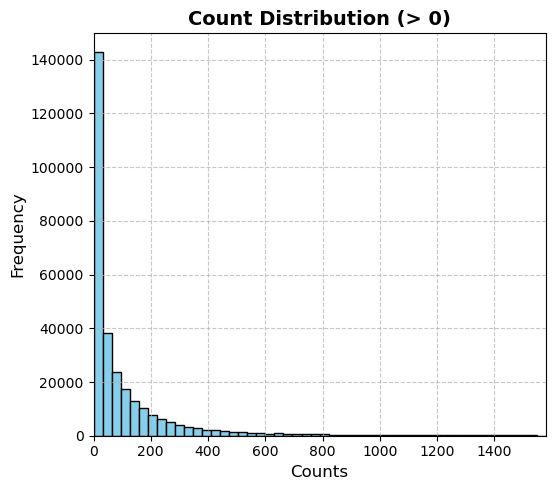

In [46]:
# Plot overall count distribution
plt.figure(figsize=(15, 5))

plt.subplot(131)
counts = df['count'][df['count'] > 0]
plt.hist(counts, bins=50, color='skyblue', edgecolor='black', range=(0, counts.quantile(0.99)))
plt.title('Count Distribution (> 0)', fontsize=14, fontweight='bold')
plt.xlabel('Counts', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlim(0, counts.quantile(0.99))

plt.tight_layout()


Outliers (counts above 99th percentile):


,feature_id,count,gene_id,exon_number
ENSG00000001629.10,20.0,2470,20.0,None
ENSG00000001630.17,1.0,2886,1.0,None
ENSG00000001630.17,2.0,2385,2.0,None
ENSG00000005108.16,2.0,3069,2.0,None
ENSG00000005249.13,11.0,6085,11.0,None


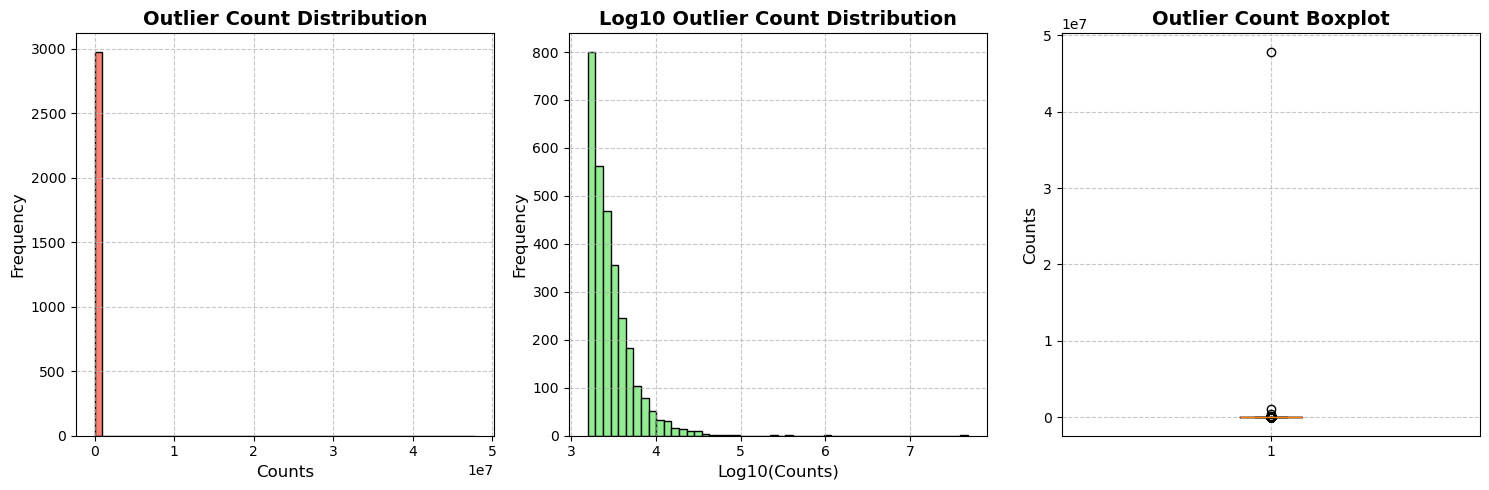

In [47]:
# Print outliers
outliers = df[df['count'] > counts.quantile(0.99)]
print("\nOutliers (counts above 99th percentile):")
# print(outliers[['feature_id', 'count', 'gene_id']].to_string(index=False))
display(outliers.head())

# Plot outliers distribution
plt.figure(figsize=(15, 5))

plt.subplot(131)
outlier_counts = outliers['count']
plt.hist(outlier_counts, bins=50, color='salmon', edgecolor='black')
plt.title('Outlier Count Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Counts', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(132)
plt.hist(np.log10(outlier_counts), bins=50, color='lightgreen', edgecolor='black')
plt.title('Log10 Outlier Count Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Log10(Counts)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(133)
plt.boxplot(outlier_counts)
plt.title('Outlier Count Boxplot', fontsize=14, fontweight='bold')
plt.ylabel('Counts', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# DEXSeq Analysis

In [102]:
def create_dexseq_dataset(sample_info, formatted_files, dexseq):
    """
    Create DEXSeqDataSet with proper sample ordering and include 'sample' as a column.
    """
    try:
        # Use the sample_info DataFrame as-is since 'sample' is now a column
        # sample_data = sample_info[['sample', 'condition']]
        sample_data = sample_info[['sample', 'condition']].copy()

        # Convert columns to string type
        sample_data['sample'] = sample_data['sample'].astype(str)
        sample_data['condition'] = sample_data['condition'].astype(str)

        # Ensure formatted_files correspond to the samples
        ordered_files = sample_info['count_file'].tolist()

        print("\nSample data for DEXSeq:")
        print(sample_data)

        print("\nOrdered count files:")
        for sample, file in zip(sample_data['sample'], ordered_files):
            print(f"{sample}: {file}")

        # Convert sample_data to an R DataFrame
        with localconverter(ro.default_converter + pandas2ri.converter):
            sample_data_r = ro.conversion.py2rpy(sample_data)

        # Convert count files list to an R vector
        count_files_vector = ro.StrVector(ordered_files)

        # After converting to R objects
        print("R sample_data:")
        print(r.str(sample_data_r))
        print("\nR count_files_vector:")
        print(r.str(count_files_vector))

        # Also, let's check the length of these objects
        print("\nLength of sample_data_r:", r.length(sample_data_r))
        print("Length of count_files_vector:", r.length(count_files_vector))

        gff_file = "gencode.v31.basic.annotation.DEXSeq.gff"
        if not os.path.exists(gff_file):
            print(f"GFF file not found: {gff_file}")
        else:
            print(f"GFF file exists: {gff_file}")
            # Print first few lines of the GFF file
            with open(gff_file, 'r') as f:
                print(f.read(500))

        # Create DEXSeqDataSet
        dxd = dexseq.DEXSeqDataSetFromHTSeq(
            countfiles=count_files_vector,
            sampleData=sample_data_r,
            # design=Formula('~ sample + exon + condition:exon'),
            design=Formula('~ condition'),
            flattenedfile=gff_file        )

        return dxd

    except Exception as e:
        print(f"Error creating DEXSeqDataSet: {str(e)}")
        raise

In [77]:
!head DexSeq_counts/EDO_1.formatted.counts

ENSG00000000003.14	001	107
ENSG00000000003.14	002	900
ENSG00000000003.14	003	340
ENSG00000000003.14	004	1
ENSG00000000003.14	005	278
ENSG00000000003.14	006	246
ENSG00000000003.14	007	262
ENSG00000000003.14	008	196
ENSG00000000003.14	009	342
ENSG00000000003.14	010	233


In [78]:
!tail DexSeq_counts/EDO_1.formatted.counts

ENSG00000288110.1	003	10
ENSG00000288110.1	004	90
ENSG00000288111.1	001	0
ENSG00000288111.1	002	0
ENSG00000288111.1	003	1
_ambiguous	None	1075741
_ambiguous_readpair_position	None	0
_empty	None	47836934
_lowaqual	None	0
_notaligned	None	0


In [79]:
%%bash
grep -P '\texonic_part\t' gencode.v31.basic.annotation.DEXSeq.gff | \
awk 'BEGIN{FS="\t"} { 
    split($9, a, ";"); 
    for (i in a) { 
        if (a[i] ~ /gene_id/) { 
            gsub(/gene_id| |"/, "", a[i]); 
            gene_id = a[i];
        } else if (a[i] ~ /exonic_part_number/) {
            gsub(/exonic_part_number| |"/, "", a[i]); 
            exon_id = a[i];
        }
    } 
    print gene_id"\t"exon_id
}' > exonic_parts_from_gff.txt

# Display the first few lines of the output file
head exonic_parts_from_gff.txt

ENSG00000223972.5	001
ENSG00000223972.5	002
ENSG00000223972.5	003
ENSG00000223972.5	004
ENSG00000223972.5	005
ENSG00000223972.5	006
ENSG00000223972.5	007
ENSG00000223972.5	008
ENSG00000223972.5	009
ENSG00000223972.5	010


In [80]:
%%bash
grep -P '\texonic_part\t' gencode.v31.basic.annotation.gff | \
awk 'BEGIN{FS="\t"} { 
    split($9, a, ";"); 
    for (i in a) { 
        if (a[i] ~ /gene_id/) { 
            gsub(/gene_id| |"/, "", a[i]); 
            gene_id = a[i];
        } else if (a[i] ~ /exonic_part_number/) {
            gsub(/exonic_part_number| |"/, "", a[i]); 
            exon_id = a[i];
        }
    } 
    print gene_id"\t"exon_id
}' > exonic_parts_from_gff.txt

# Display the first few lines of the output file
head exonic_parts_from_gff.txt

ENSG00000223972.5	001
ENSG00000223972.5	002
ENSG00000223972.5	003
ENSG00000223972.5	004
ENSG00000223972.5	005
ENSG00000223972.5	006
ENSG00000223972.5	007
ENSG00000223972.5	008
ENSG00000223972.5	009
ENSG00000223972.5	010


In [81]:
!grep ENSG00000000003.14 exonic_parts_from_gff.txt

ENSG00000000003.14	001
ENSG00000000003.14	002
ENSG00000000003.14	003
ENSG00000000003.14	004
ENSG00000000003.14	005
ENSG00000000003.14	006
ENSG00000000003.14	007
ENSG00000000003.14	008
ENSG00000000003.14	009
ENSG00000000003.14	010
ENSG00000000003.14	011
ENSG00000000003.14	012


In [82]:
!grep ENSG00000223972.5 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_1.formatted.counts

ENSG00000223972.5	001	0
ENSG00000223972.5	002	0
ENSG00000223972.5	003	0
ENSG00000223972.5	004	0
ENSG00000223972.5	005	0
ENSG00000223972.5	006	0
ENSG00000223972.5	007	0
ENSG00000223972.5	008	0
ENSG00000223972.5	009	0
ENSG00000223972.5	010	3
ENSG00000223972.5	011	4


In [83]:
!wc -l /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/*.formatted.counts

  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_1.formatted.counts
  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_2.formatted.counts
  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_3.formatted.counts
  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_1.formatted.counts
  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_2.formatted.counts
  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_3.formatted.counts
  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_1.formatted.counts
  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_2.formatted.counts
  393424 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_3.formatted.counts
 3540816 total


In [84]:
!head -n 10 /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/gencode.v31.basic.annotation.DEXSeq.gff

chr1	dexseq_prepare_annotation.py	aggregate_gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"
chr1	dexseq_prepare_annotation.py	exonic_part	11869	12009	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2"; exonic_part_number "001"
chr1	dexseq_prepare_annotation.py	exonic_part	12010	12057	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "002"
chr1	dexseq_prepare_annotation.py	exonic_part	12058	12178	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2"; exonic_part_number "003"
chr1	dexseq_prepare_annotation.py	exonic_part	12179	12227	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "004"
chr1	dexseq_prepare_annotation.py	exonic_part	12613	12697	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "005"
chr1	dexseq_prepare_annotation.py	exonic_part	12698	12721	.	+	.	gene_id "ENSG00000223972.5"; tra

In [85]:
sample_info

,sample,condition,replicate,count_file
0,EDO_1,EDO,1,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
1,ND1_3,ND1,3,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
2,PW1_2,PW1,2,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
3,EDO_2,EDO,2,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
4,ND1_2,ND1,2,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
5,EDO_3,EDO,3,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
6,PW1_1,PW1,1,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
7,PW1_3,PW1,3,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...
8,ND1_1,ND1,1,/beegfs/scratch/ric.broccoli/kubacki.michal/SR...


In [86]:
count_files

['/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_1.formatted.counts',
 '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_3.formatted.counts',
 '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_2.formatted.counts',
 '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_2.formatted.counts',
 '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_3.formatted.counts',
 '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_1.formatted.counts']

In [87]:
for file in count_files:
    if not os.path.exists(file):
        print(f"File not found: {file}")

In [97]:
with open(count_files[0], 'r') as f:
    print(f.read(100))

ENSG00000000003.14	001	107
ENSG00000000003.14	002	900
ENSG00000000003.14	003	340
ENSG00000000003.14	


In [103]:
dxd = create_dexseq_dataset(sample_info, count_files, dexseq)


Sample data for DEXSeq:
  sample condition
0  EDO_1       EDO
1  ND1_3       ND1
2  PW1_2       PW1
3  EDO_2       EDO
4  ND1_2       ND1
5  EDO_3       EDO
6  PW1_1       PW1
7  PW1_3       PW1
8  ND1_1       ND1

Ordered count files:
EDO_1: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_1.formatted.counts
ND1_3: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_3.formatted.counts
PW1_2: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_2.formatted.counts
EDO_2: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_2.formatted.counts
ND1_2: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_2.formatted.counts
EDO_3: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_3.formatted.counts
PW1_1: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_1.formatted.counts
PW1_3: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_c

R[write to console]: Error in FUN(X[[i]], ...) : subscript out of bounds



Error creating DEXSeqDataSet: Error in FUN(X[[i]], ...) : subscript out of bounds



RRuntimeError: Error in FUN(X[[i]], ...) : subscript out of bounds


In [47]:

def format_count_file(input_file, output_dir):
    """
    Format count file for DEXSeq with proper space handling
    """
    output_file = os.path.join(output_dir, os.path.basename(input_file).replace('.dexeq_counts', '.formatted.counts'))
    
    try:
        print(f"\nProcessing file: {os.path.basename(input_file)}")
        
        # Read file using tab separator
        df = pd.read_csv(input_file, sep='\t', header=None, 
                         names=['feature_id', 'count'],
                         quoting=3)  # Turn off quoting
        
        print(f"Read {len(df)} lines from file")
        print("\nFirst few lines of input:")
        print(df.head())
        
        # Process feature IDs
        processed_data = []
        for _, row in df.iterrows():
            feature_id = row['feature_id'].strip('"')  # Remove outer quotes
            count = row['count']
            
            # Handle special entries
            if feature_id.startswith('_'):
                processed_data.append([feature_id, '0', str(int(count))])
            else:
                try:
                    # Split feature ID into components
                    gene_id, exon_num = feature_id.split('":"')
                    exon_num = exon_num.strip('"')
                    
                    # Format line for DEXSeq
                    processed_data.append([gene_id, exon_num, str(int(count))])
                except Exception as e:
                    print(f"Error processing line {feature_id}: {str(e)}")
                    continue
        
        if not processed_data:
            raise ValueError("No valid data was processed")
            
        # Create and save formatted DataFrame
        formatted_df = pd.DataFrame(processed_data, 
                                    columns=['gene_id', 'exon_id', 'count'])
        
        # Save without index and headers, tab-separated
        formatted_df.to_csv(output_file, sep='\t', index=False, header=False)
        
        print(f"\nProcessed file: {os.path.basename(output_file)}")
        print("First few lines of output:")
        print(formatted_df.head().to_string(index=False))
        
        return output_file
        
    except Exception as e:
        print(f"Error formatting file {input_file}: {str(e)}")
        return None

def prepare_sample_info(sample_info):
    """
    Prepare sample information DataFrame
    """
    try:
        # Filter for EDO and ND1 samples
        samples = sample_info[sample_info['condition'].isin(['EDO', 'ND1'])].copy()
        
        # Reset index
        samples = samples.reset_index(drop=True)
        
        # Convert data types
        samples['sample'] = samples['sample'].astype(str)
        samples['condition'] = pd.Categorical(samples['condition'])
        samples['replicate'] = samples['replicate'].astype(str)
        
        # Set sample as index
        samples.set_index('sample', inplace=True)
        
        return samples
        
    except Exception as e:
        print(f"Error preparing sample info: {str(e)}")
        return None

def create_dexseq_dataset(sample_info, formatted_files, dexseq):
    """
    Create DEXSeqDataSet with proper sample ordering and include 'sample' as a column.
    """
    try:
        # Reset index to have 'sample' as a column
        sample_data = sample_info.reset_index()

        # Ensure 'sample' and 'condition' are present
        sample_data = sample_data[['sample', 'condition']]

        # Convert 'sample' and 'condition' to string (if not already)
        sample_data['sample'] = sample_data['sample'].astype(str)
        sample_data['condition'] = sample_data['condition'].astype(str)

        # Create a mapping of sample names to their corresponding count files
        sample_to_file = {}
        for file_path in formatted_files:
            sample_name = os.path.splitext(os.path.basename(file_path))[0].replace('.formatted', '')
            sample_to_file[sample_name] = file_path

        # Order the count files to match the sample_data order
        ordered_files = []
        for sample in sample_data['sample']:
            if sample not in sample_to_file:
                raise ValueError(f"Sample {sample} not found in count files")
            ordered_files.append(sample_to_file[sample])

        print("\nSample data for DEXSeq:")
        print(sample_data)

        print("\nOrdered count files:")
        for sample, file in zip(sample_data['sample'], ordered_files):
            print(f"{sample}: {os.path.basename(file)}")

        # Convert to R
        with localconverter(ro.default_converter + pandas2ri.converter):
            sample_data_r = ro.conversion.py2rpy(sample_data)

        # Create count files vector with correct ordering
        count_files_vector = ro.StrVector(ordered_files)

        # Create DEXSeqDataSet
        dxd = dexseq.DEXSeqDataSetFromHTSeq(
            countfiles=count_files_vector,
            sampleData=sample_data_r,
            design=Formula('~ sample + exon + condition:exon'),
            flattenedfile="/beegfs/scratch/ric.broccoli/ric.broccoli/PW_RNA_seq_deep/gencode.v31.basic.annotation.DEXSeq.gff"
        )

        return dxd

    except Exception as e:
        print(f"Error creating DEXSeqDataSet: {str(e)}")
        raise

In [ ]:
# Create output directory
temp_dir = "temp_dexseq_counts"
os.makedirs(temp_dir, exist_ok=True)

# Format count files
print("\nFormatting count files...")
formatted_files = []
for _, row in edo_nd1_samples.iterrows():
    formatted_file = format_count_file(row['count_file'], temp_dir)
    if formatted_file:
        formatted_files.append(formatted_file)

if not formatted_files:
    raise ValueError("No files were formatted successfully")

In [ ]:
# Extract sample names from formatted files
sample_names = [os.path.splitext(os.path.basename(file))[0] for file in formatted_files]

# Prepare sample information
print("\nPreparing sample information...")
# Reset index to include 'sample' as a column
sample_info = edo_nd1_samples.reset_index()

# Update 'count_file' paths to the formatted files
sample_info['count_file'] = formatted_files

# Update 'sample' column with the correct names
sample_info['sample'] = sample_names

# Ensure proper data types
sample_info['sample'] = sample_info['sample'].astype(str)
sample_info['condition'] = sample_info['condition'].astype(str)
sample_info['replicate'] = sample_info['replicate'].astype(str)

# Now, sample_info should have 'sample' as a column with the correct sample names
print("\nUpdated sample_info DataFrame:")
print(sample_info)

In [ ]:
# Create DEXSeqDataSet
print("\nCreating DEXSeqDataSet...")
dexseq = importr('DEXSeq')
dxd = create_dexseq_dataset(sample_info, formatted_files, dexseq)

In [ ]:
sample_info

In [ ]:
formatted_files

In [ ]:
# Import R packages and create DEXSeqDataSet
print("\nCreating DEXSeqDataSet...")
dexseq = importr('DEXSeq')
dxd = create_dexseq_dataset(sample_info, formatted_files, dexseq)

In [ ]:
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)


In [ ]:
# Create DEXSeqDataSet with the filtered samples
dxd = dexseq.DEXSeqDataSetFromHTSeq(
    countfiles=ro.StrVector(edo_nd1_samples['count_file'].tolist()),
    sampleData=edo_nd1_samples,
    design=r('~ sample + exon + condition:exon'),
    flattenedfile=os.path.join(working_dir, "gencode.v31.basic.annotation.gff")
)

In [101]:
import os
import pandas as pd
import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, r
import rpy2.robjects as ro
import matplotlib.pyplot as plt
import seaborn as sns

# Enable automatic conversion between pandas and R dataframes
pandas2ri.activate()

def format_count_file_for_dexseq(input_file, output_file):
    """
    Reformat count file to match DEXSeq expectations:
    From: "ENSG00000000003.14":"001"    107
    To:   ENSG00000000003.14    001    107
    """
    try:
        # Read the original file
        df = pd.read_csv(input_file, sep='\t', header=None, 
                        names=['feature_id', 'count'])
        
        # Split the feature_id into gene_id and exon_number
        df['gene_id'] = df['feature_id'].apply(lambda x: x.split(':')[0].strip('"'))
        df['exon_number'] = df['feature_id'].apply(lambda x: x.split(':')[1].strip('"') if ':' in x else None)
        
        # Write in DEXSeq expected format
        with open(output_file, 'w') as f:
            for _, row in df.iterrows():
                if row['exon_number'] is not None:
                    f.write(f"{row['gene_id']}\t{row['exon_number']}\t{row['count']}\n")
                else:
                    # Handle special cases like _ambiguous, _empty, etc.
                    f.write(f"{row['feature_id']}\t0\t{row['count']}\n")
                    
        return True
    except Exception as e:
        print(f"Error formatting file {input_file}: {str(e)}")
        return False

def prepare_sample_info(sample_info_df):
    """
    Prepare sample information and reformat count files.
    """
    # Filter for EDO and ND1 samples
    edo_nd1_samples = sample_info_df[sample_info_df['condition'].isin(['EDO', 'ND1'])].copy()
    edo_nd1_samples = edo_nd1_samples.reset_index(drop=True)
    
    # Create reformatted count files
    reformatted_files = []
    for idx, row in edo_nd1_samples.iterrows():
        original_file = row['count_file']
        reformatted_file = original_file + '.reformatted'
        if format_count_file_for_dexseq(original_file, reformatted_file):
            reformatted_files.append(reformatted_file)
        else:
            raise Exception(f"Failed to format count file: {original_file}")
    
    # Update count_file paths
    edo_nd1_samples['count_file'] = reformatted_files
    
    # Ensure proper categorical variables
    edo_nd1_samples['condition'] = pd.Categorical(edo_nd1_samples['condition'])
    edo_nd1_samples['replicate'] = pd.Categorical(edo_nd1_samples['replicate'])
    
    return edo_nd1_samples

def run_dexseq_analysis(sample_info_df, working_dir, padj_threshold=0.05, log2fc_threshold=1.0):
    """
    Run DEXSeq analysis with reformatted files.
    """
    print("Sample groups in data:")
    print(sample_info_df['condition'].value_counts())
    
    # Prepare samples and reformat files
    print("\nPreparing count files...")
    edo_nd1_samples = prepare_sample_info(sample_info_df)
    print("\nFiltered samples:")
    print(edo_nd1_samples)
    
    try:
        # Import R packages
        dexseq = importr('DEXSeq')
        deseq2 = importr('DESeq2')
        
        # Create DEXSeqDataSet
        print("\nCreating DEXSeqDataSet...")
        dxd = dexseq.DEXSeqDataSetFromHTSeq(
            countfiles=ro.StrVector(edo_nd1_samples['count_file'].tolist()),
            sampleData=edo_nd1_samples,
            design=r('~ sample + exon + condition:exon'),
            flattenedfile=os.path.join(working_dir, "gencode.v31.basic.annotation.gff")
        )
        
        # Continue with analysis as before...
        print("Estimating size factors...")
        dxd = dexseq.estimateSizeFactors(dxd)
        
        print("Estimating dispersions...")
        r.pdf("dispersion_estimates.pdf")
        dxd = dexseq.estimateDispersions(dxd, quiet=False)
        r('dev.off()')
        
        print("Testing for differential exon usage...")
        dxd = dexseq.testForDEU(dxd)
        dxd = dexseq.estimateExonFoldChanges(dxd, fitExpToVar="condition")
        
        # Get results
        print("Processing results...")
        res = dexseq.DEXSeqResults(dxd)
        res_df = pandas2ri.rpy2py_dataframe(res)
        
        # Process results
        return process_results(res_df, padj_threshold, log2fc_threshold)
        
    except Exception as e:
        print(f"Error in DEXSeq analysis: {str(e)}")
        raise
    finally:
        # Clean up reformatted files
        for file in edo_nd1_samples['count_file']:
            if os.path.exists(file):
                os.remove(file)

def process_results(res_df, padj_threshold, log2fc_threshold):
    """
    Process DEXSeq results with corrected statistics.
    """
    # Add detailed statistics
    results_with_stats = res_df.copy()
    results_with_stats['log2FoldChange'] = np.log2(res_df['exonBaseMean'].replace(0, np.nan))
    
    # Handle potential infinity values
    results_with_stats['log2FoldChange'] = results_with_stats['log2FoldChange'].replace([np.inf, -np.inf], np.nan)
    
    # Calculate percentage usage
    results_with_stats['percentageUsage'] = (res_df['countData'] / 
                                           res_df['exonBaseMean'].replace(0, np.nan) * 100)

    # Filter significant results
    significant_results = results_with_stats[
        (results_with_stats['padj'] < padj_threshold) & 
        (abs(results_with_stats['log2FoldChange']) > log2fc_threshold)
    ].copy()

    # Generate summary statistics
    summary_stats = create_summary_statistics(results_with_stats, significant_results)
    
    # Create visualizations
    create_visualization_plots(results_with_stats, significant_results, 
                             padj_threshold, log2fc_threshold)

    # Save results
    save_results(results_with_stats, significant_results, summary_stats)

    return results_with_stats, significant_results, summary_stats

def create_summary_statistics(results_df, significant_df):
    """
    Create summary statistics with proper handling of NaN values.
    """
    return pd.DataFrame({
        'Metric': [
            'Total Exons Tested',
            'Significant Exons (padj < 0.05)',
            'Mean Log2 Fold Change (significant)',
            'Median adjusted p-value (significant)',
            'Number of Upregulated Exons',
            'Number of Downregulated Exons'
        ],
        'Value': [
            len(results_df),
            len(significant_df),
            significant_df['log2FoldChange'].mean(),
            significant_df['padj'].median(),
            sum(significant_df['log2FoldChange'] > 0),
            sum(significant_df['log2FoldChange'] < 0)
        ]
    })

def create_volcano_plot(results_df, padj_threshold, log2fc_threshold):
    plt.scatter(results_df['log2FoldChange'], -np.log10(results_df['padj']), alpha=0.5)
    plt.axhline(-np.log10(padj_threshold), color='red', linestyle='--')
    plt.axvline(-log2fc_threshold, color='red', linestyle='--')
    plt.axvline(log2fc_threshold, color='red', linestyle='--')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 Adjusted p-value')
    plt.title('Volcano Plot')

def create_ma_plot(results_df):
    plt.scatter(np.log10(results_df['baseMean']), results_df['log2FoldChange'], alpha=0.5)
    plt.xlabel('Log10 Mean Expression')
    plt.ylabel('Log2 Fold Change')
    plt.title('MA Plot')
    plt.axhline(y=0, color='r', linestyle='--')
    
def create_visualization_plots(results_df, significant_df, padj_threshold, log2fc_threshold):
    """
    Create visualization plots with proper data handling.
    """
    plt.figure(figsize=(15, 10))

    # Volcano plot
    plt.subplot(2, 2, 1)
    create_volcano_plot(results_df, padj_threshold, log2fc_threshold)

    # MA plot
    plt.subplot(2, 2, 2)
    create_ma_plot(results_df)

    # Save plots
    plt.tight_layout()
    plt.savefig('dexseq_analysis_plots.pdf')
    plt.close()

def save_results(results_df, significant_df, summary_stats):
    """
    Save analysis results to files.
    """
    results_df.to_csv("all_dexseq_results.csv", index=False)
    significant_df.to_csv("significant_dexseq_results.csv", index=False)
    summary_stats.to_csv("analysis_summary.csv", index=False)

In [108]:
def check_file_format(file_path):
    """
    Check if the file format is correct and print diagnostic information.
    """
    print(f"\nChecking file: {file_path}")
    try:
        with open(file_path, 'r') as f:
            first_lines = [next(f) for _ in range(5)]
        print("First 5 lines:")
        for line in first_lines:
            print(line.strip())
        return True
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return False

def format_count_file_for_dexseq(input_file, output_file):
    """
    Reformat count file to match DEXSeq expectations.
    """
    try:
        print(f"\nFormatting file: {input_file}")
        # Read the original file
        df = pd.read_csv(input_file, sep='\t', header=None, 
                        names=['feature_id', 'count'], quoting=3)
        
        # Split the feature_id into gene_id and exon_number
        def parse_feature_id(feature_id):
            if feature_id.startswith('*') or feature_id.startswith('_'):
                return feature_id, 'NA'
            try:
                parts = feature_id.replace('"', '').split(':')
                gene_id = parts[0]
                exon_number = parts[1] if len(parts) > 1 else 'NA'
                return gene_id, exon_number
            except:
                return feature_id, 'NA'
        
        # Apply parsing
        df[['gene_id', 'exon_number']] = df.apply(
            lambda x: pd.Series(parse_feature_id(x['feature_id'])), axis=1)
        
        # Write in DEXSeq expected format
        df.to_csv(output_file, sep='\t', 
                 columns=['gene_id', 'exon_number', 'count'],
                 header=False, index=False)
        
        # Verify the output
        print("\nVerifying output file format:")
        check_file_format(output_file)
        
        return True
    except Exception as e:
        print(f"Error formatting file {input_file}: {str(e)}")
        return False

def prepare_sample_info(sample_info_df):
    """
    Prepare sample information and print diagnostic information.
    """
    print("\nPreparing sample information:")
    print("Original sample info:")
    print(sample_info_df)
    
    # Filter for EDO and ND1 samples
    edo_nd1_samples = sample_info_df[sample_info_df['condition'].isin(['EDO', 'ND1'])].copy()
    edo_nd1_samples = edo_nd1_samples.reset_index(drop=True)
    
    # Sort by condition and replicate
    edo_nd1_samples = edo_nd1_samples.sort_values(['condition', 'replicate'])
    
    print("\nFiltered and sorted sample info:")
    print(edo_nd1_samples)
    
    # Create reformatted count files
    reformatted_files = []
    for idx, row in edo_nd1_samples.iterrows():
        original_file = row['count_file']
        reformatted_file = original_file + '.reformatted'
        if format_count_file_for_dexseq(original_file, reformatted_file):
            reformatted_files.append(reformatted_file)
        else:
            raise Exception(f"Failed to format count file: {original_file}")
    
    # Update count_file paths
    edo_nd1_samples['count_file'] = reformatted_files
    
    # Convert to categorical
    edo_nd1_samples['condition'] = pd.Categorical(edo_nd1_samples['condition'])
    edo_nd1_samples['replicate'] = pd.Categorical(edo_nd1_samples['replicate'])
    
    print("\nFinal sample information:")
    print(edo_nd1_samples)
    
    # Verify all files exist
    print("\nVerifying count files:")
    for file in edo_nd1_samples['count_file']:
        print(f"{file}: {os.path.exists(file)}")
    
    return edo_nd1_samples

def run_dexseq_analysis(sample_info_df, working_dir, padj_threshold=0.05, log2fc_threshold=1.0):
    """
    Run DEXSeq analysis with additional error checking.
    """
    print("\nStarting DEXSeq analysis...")
    print(f"Working directory: {working_dir}")
    
    # Verify GFF file
    gff_file = os.path.join(working_dir, "gencode.v31.basic.annotation.gff")
    if not os.path.exists(gff_file):
        raise FileNotFoundError(f"GFF file not found: {gff_file}")
    print(f"GFF file exists: {gff_file}")
    
    # Prepare samples
    try:
        edo_nd1_samples = prepare_sample_info(sample_info_df)
        
        # Import R packages
        print("\nImporting R packages...")
        dexseq = importr('DEXSeq')
        deseq2 = importr('DESeq2')
        
        # Convert sample information to R
        print("\nConverting sample information to R format...")
        r_sample_data = pandas2ri.py2rpy(edo_nd1_samples)
        
        # Create DEXSeqDataSet
        print("\nCreating DEXSeqDataSet...")
        print("Count files:")
        for file in edo_nd1_samples['count_file']:
            print(f"- {file}")
            
        dxd = dexseq.DEXSeqDataSetFromHTSeq(
            countfiles=ro.StrVector(edo_nd1_samples['count_file'].tolist()),
            sampleData=r_sample_data,
            design=r('~ sample + exon + condition:exon'),
            flattenedfile=gff_file
        )
        
        # Continue with analysis...
        print("Running DEXSeq pipeline...")
        
        return run_dexseq_pipeline(dxd, dexseq, padj_threshold, log2fc_threshold)
        
    except Exception as e:
        print(f"Error in DEXSeq analysis: {str(e)}")
        raise
        
def run_dexseq_pipeline(dxd, dexseq, padj_threshold, log2fc_threshold):
    """
    Run the DEXSeq pipeline steps with error checking.
    """
    try:
        print("Estimating size factors...")
        dxd = dexseq.estimateSizeFactors(dxd)
        
        print("Estimating dispersions...")
        r.pdf("dispersion_estimates.pdf")
        dxd = dexseq.estimateDispersions(dxd, quiet=False)
        r('dev.off()')
        
        print("Testing for differential exon usage...")
        dxd = dexseq.testForDEU(dxd)
        
        print("Estimating exon fold changes...")
        dxd = dexseq.estimateExonFoldChanges(dxd, fitExpToVar="condition")
        
        print("Getting results...")
        res = dexseq.DEXSeqResults(dxd)
        res_df = pandas2ri.rpy2py_dataframe(res)
        
        return process_results(res_df, padj_threshold, log2fc_threshold)
        
    except Exception as e:
        print(f"Error in DEXSeq pipeline: {str(e)}")
        raise


In [ ]:
# First, print current state
print("Current working directory:", os.getcwd())
print("\nSample information:")
print(sample_info)

try:
    results, significant_results, summary = run_dexseq_analysis(
        sample_info, 
        working_dir="/beegfs/scratch/ric.broccoli/kubacki.michal/PW_RNA_seq_deep",
        padj_threshold=0.05,
        log2fc_threshold=1.0
    )
    
except Exception as e:
    print(f"\nError in analysis: {str(e)}")
    print("\nFull error information:")
    import traceback
    traceback.print_exc()

In [ ]:
# Create DEXSeqDataSet with the filtered samples
dxd = dexseq.DEXSeqDataSetFromHTSeq(
    countfiles=ro.StrVector(edo_nd1_samples['count_file'].tolist()),
    sampleData=edo_nd1_samples,
    design=r('~ sample + exon + condition:exon'),
    flattenedfile=os.path.join(working_dir, "gencode.v31.basic.annotation.gff")
)

In [ ]:
if df is not None:
    # Log count distribution
    plt.subplot(132)
    plt.hist(np.log10(df['count'][df['count'] > 0]), bins=50)
    plt.title('Log10 Count Distribution')
    plt.xlabel('Log10(Counts)')
    plt.ylabel('Frequency')
    
    # Box plot
    plt.subplot(133)
    df_filtered = df[~df['feature_id'].str.startswith('*')]
    plt.boxplot(df_filtered['count'])
    plt.title('Count Boxplot\n(excluding special features)')
    plt.ylabel('Counts')
    
    plt.tight_layout()
    plt.savefig('count_distributions.pdf')
    plt.close()
    
    # Examine genes of interest
    genes_of_interest = ["SETD5", "NSD2", "POLE", "HTT", "PER3", "MED14"]
    examine_genes_of_interest(df, genes_of_interest)

In [ ]:




# Plot count distributions
print("\nPlotting count distributions...")
plot_count_distributions(count_files[:3])  # Examine first 3 files
plt.savefig('count_distributions.pdf')

In [ ]:
print("\nChecking for issues in files:")
for file_path in count_files:
    issues = check_file_issues(file_path)
    if issues:
        print(f"\n{os.path.basename(file_path)}:")
        for issue in issues:
            print(f"- {issue}")

# Save summary to file
with open('dexseq_counts_summary.txt', 'w') as f:
    f.write("DEXSeq Count Files Summary\n")
    f.write("=========================\n\n")
    f.write("File Structure Comparison:\n")
    f.write(structure_comparison.to_string())
    f.write("\n\nSample Statistics:\n")
    for file_path in count_files:
        df = pd.read_csv(file_path, sep='\t', header=None)
        f.write(f"\n{os.path.basename(file_path)}:\n")
        f.write(df[2].describe().to_string())

print("\nAnalysis complete. Check 'dexseq_counts_summary.txt' for detailed summary.")

In [24]:
# Ensure proper formatting for DEXSeq
edo_nd1_samples = edo_nd1_samples.reset_index(drop=True)
edo_nd1_samples['condition'] = pd.Categorical(edo_nd1_samples['condition'])
edo_nd1_samples['replicate'] = pd.Categorical(edo_nd1_samples['replicate'])

In [ ]:
# Create DEXSeqDataSet with the filtered samples
dxd = dexseq.DEXSeqDataSetFromHTSeq(
    countfiles=ro.StrVector(edo_nd1_samples['count_file'].tolist()),
    sampleData=edo_nd1_samples,
    design=r('~ sample + exon + condition:exon'),
    flattenedfile=os.path.join(working_dir, "gencode.v31.basic.annotation.gff")
)

# BAM FILES

In [3]:
# Define paths for RNA-seq data
bam_dir = os.path.join(data_dir, "Bam_file")
bam_files = [f for f in os.listdir(bam_dir) if f.endswith('.bam')]

In [ ]:
print(bam_files)

In [ ]:
# Separate patient and control files
EDO = [f for f in bam_files if 'EDO' in f]
PW1 = [f for f in bam_files if 'PW1' in f]
ND1 = [f for f in bam_files if 'ND1' in f]
print(EDO)
print(PW1)
print(ND1)

In [9]:
# Define the genes of interest from the pull-down experiment
genes_of_interest = ["SETD5", "NSD2", "POLE", "HTT", "PER3", "MED14"]

In [11]:
def extract_gene_coverage(bam_file, gene_regions):
    coverage = {}
    with pysam.AlignmentFile(bam_file, "rb") as bam:
        for gene, region in gene_regions.items():
            chrom, start, end = region
            coverage[gene] = bam.count_coverage(chrom, start, end)
    return coverage